<a href="https://colab.research.google.com/github/dragoon-lzt/Bayesian-Theory-and-Computation/blob/main/HW/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm


## Problem 2.
### (5)
simulation: 

In [79]:
# one-step transition function
def transfunc(i):
  if i==0:
    a = np.random.rand()
    if a < 0.5:
      return 0
    else:
      return 1
  else:
    a = np.random.rand()
    if a>0.5:
      return i-1
    elif a<1/(2*(i+1)):
      return i+1
    else:
      return i

# set random seed
np.random.seed(1024)

X0=1
X = np.zeros(10000)
X[0] = transfunc(X0)
for t in range(1,10000):
  X[t] = transfunc(X[t-1])
mu = np.mean(X)
sigma = np.var(X) 

print("mean     = ", mu)
print("variance = ", sigma)

mean     =  0.9698
variance =  0.92548796


## Problem 3.


### (3)


Gibbs sampler for simulating from the joint posterior. 

In [80]:
def Gibbs_Sampler(y, J, rho, 
          mu0, sigma0, tau0, phi0):

  # renew mu
  a_mu = ((1-rho)*phi0.sum()+rho*(phi0[0]+phi0[J-1]))/(J-(J-2)*rho)
  b_mu = sigma0/np.sqrt((1-rho)*(J-(J-2)*rho))
  mu0 = np.random.normal(a_mu, b_mu)

  # renew sigma
  phi0_mu0 = phi0-mu0
  S = (1-rho*rho) * phi0_mu0[0]*phi0_mu0[0]
  for j in range(J-1):
    S = S+ (phi0_mu0[j+1] - rho * phi0_mu0[j])*(phi0_mu0[j+1] - rho * phi0_mu0[j])
  k1 = 2/S
  delta = np.random.gamma((J-2)/2,k1)
  sigma0 = 1/np.sqrt(delta)

  # renew tau
  S_y = ((y-phi0)*(y-phi0)).sum() + 1
  k2 = 2/S_y
  eta = np.random.gamma(J/2+1,k2)
  tau0 = 1/np.sqrt(eta)

  # renew phi
  ## \phi_1
  b1 = 1/np.sqrt(delta+eta)
  a1 = (y[0]*eta + delta*(mu0+rho*(phi[1]-mu0)) ) / (eta + delta)
  phi0[1] = np.random.normal(a1,b1)
  ## \phi_j
  bj = 1/np.sqrt(eta + delta*(1+rho*rho))
  for j in range(1,J-1):
    aj = (y[j-1]*eta + delta*(mu0*(1-rho)*(1-rho)+rho*(phi[j-2]+phi[j])) ) / (eta + delta*(1+rho*rho))
    phi0[j] = np.random.normal(aj,bj)
  ## \phi_J
  aJ = (y[J-1]*eta + delta*(mu0+rho*(phi[J-2]-mu0)) ) / (eta + delta)
  phi0[J-1] = np.random.normal(aJ,b1)

  return mu0, sigma0, tau0, phi0

### (4)

Simulate a data set with $J=100$, $\rho=0.8$, $\tau^2=\sigma^2=1$

In [81]:
J=100
rho=0.8
mu = 0
tau =1
sigma=1
phi = np.zeros(J)
y = np.zeros(J)

# set random seed
np.random.seed(54651321)

phi[0] = np.random.normal(mu,sigma/np.sqrt(1-rho*rho))
for j in range(0,J-1):
  phi[j+1] = np.random.normal(mu+rho*(phi[j]-mu),sigma)
for j in range(J):
  y[j] = np.random.normal(phi[j],tau)
# plt.plot(np.arange(1,J+1),y)

Use you Gibbs sampler to simulate from the posterior.

In [82]:
#@title
n = 1000

# set random seed
np.random.seed(865)

mu_ = np.zeros(n)
sigma_ = np.ones(n) 
tau_ = np.ones(n)
phi_ = np.zeros((n,J))

for i in range(1,n):
  mu_[i], sigma_[i], tau_[i], phi_[i,:] = Gibbs_Sampler(y,J,rho, mu_[i-1],sigma_[i-1],tau_[i-1],phi_[i-1,:]) 


$\mu$

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(-3.0, 43.0)

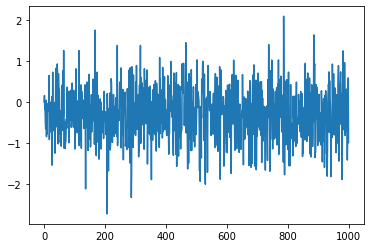

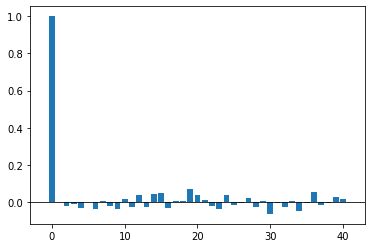

In [83]:
plt.figure()
plt.plot(mu_)
plt.figure()
acf_mu = acf(mu_)
plt.bar(x=list(range(len(acf_mu))) ,height=acf_mu,label=['acf','lag'])
plt.plot([-5,45],[0,0],color='black',linewidth=0.8)
plt.xlim(-3,43)


$\sigma^2$

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(-3.0, 43.0)

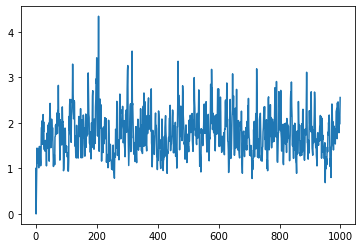

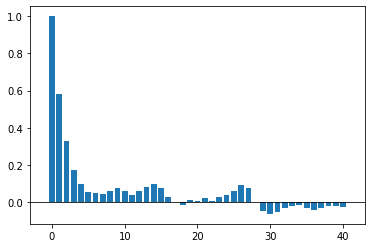

In [84]:
plt.figure()
plt.plot(sigma_*sigma_)
plt.figure()
acf_sigma2 = acf(sigma_*sigma_)
plt.bar(x=list(range(len(acf_sigma2))) ,height=acf_sigma2,label=['acf','lag'])
plt.plot([-5,45],[0,0],color='black',linewidth=0.8)
plt.xlim(-3,43)


$\tau^2$

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(-3.0, 43.0)

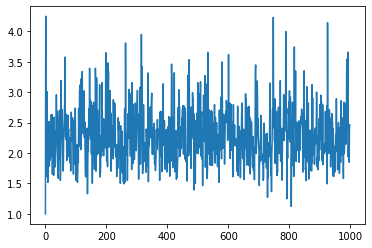

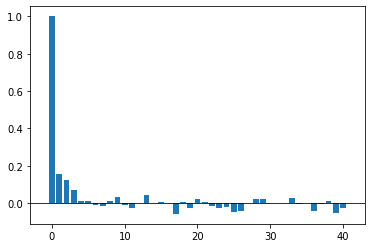

In [85]:
plt.figure()
plt.plot(tau_*tau_)
plt.figure()
acf_tau2 = acf(tau_*tau_)
plt.bar(x=list(range(len(acf_tau2))) ,height=acf_tau2,label=['acf','lag'])
plt.plot([-5,45],[0,0],color='black',linewidth=0.8)
plt.xlim(-3,43)

### (5)
Based on the Gibbs draws, plot the marginal posteriors of $\mu$, $\sigma$ and $\tau$ and compare with the true values.

 


The red line represent the true value. 

The green block is the $95\%$ credible intervals.

$\mu$

CI=( -1.5602497777899225 , 0.9035451277749248 )


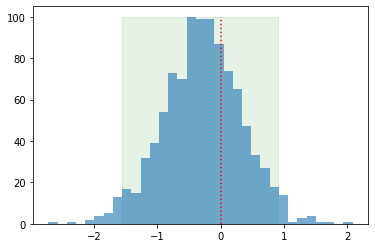

In [91]:
#@title  { form-width: "80px" }
plt.figure() 
height,bins,patche = plt.hist(mu_,bins=33,histtype="bar",alpha=0.612)
plt.plot([0,0],[0,height.max()],":",color="r")

# get 95% c.i.
ci = [np.percentile(mu_,2.5),np.percentile(mu_,97.5)] 
# Mark between 0 and the highest bar in the histogram
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1) 
print("CI=(",ci[0],",",ci[1],")")

$\sigma^2$

CI=( 0.9989441819448985 , 2.748098063963359 )


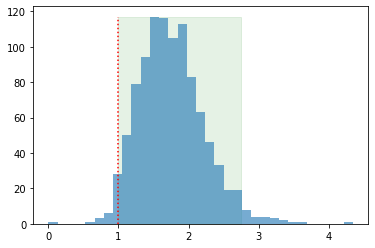

In [87]:
plt.figure() 
height,bins,patche = plt.hist(sigma_*sigma_,bins=33,histtype="bar",alpha=0.612)
plt.plot([1,1],[0,height.max()],":",color="r")

# get 95% c.i.
ci = [np.percentile(sigma_*sigma_,2.5),np.percentile(sigma_*sigma_,97.5)] 
# Mark between 0 and the highest bar in the histogram
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)  
print("CI=(",ci[0],",",ci[1],")")

$\tau^2$

CI=( 1.5513713509488662 , 3.3379838565290014 )


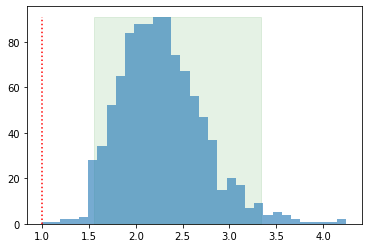

In [92]:
plt.figure()
# get 95% c.i.
ci = [np.percentile(tau_*tau_,2.5),np.percentile(tau_*tau_,97.5)] 
height,bins,patche = plt.hist(tau_*tau_,bins=33,histtype="bar",alpha=0.612)
plt.plot([1,1],[0,height.max()],":",color="r")
# Mark between 0 and the highest bar in the histogram
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1) 
print("CI=(",ci[0],",",ci[1],")")